In [1]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
import pandas as pd
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from Performance import performance_evaluation
perfs = performance_evaluation()

from Performance import H2h_Regret_Evaluation
h2h_regret_eva = H2h_Regret_Evaluation()

from Data import Data_Simulator
DS_Obj = Data_Simulator()

from Oracle import Oracle_Processing
Oracle_Proc = Oracle_Processing()

from OLS import OLS_Processing
OLS_Proc = OLS_Processing()

from DDR import DDR_Processing
DDR_Proc = DDR_Processing()

from PYEPO import EPO_Processing
PYEPO_Proc = EPO_Processing()

from Data_Load_Store import Load_Store_Methods
Data_LSM = Load_Store_Methods()

In [2]:
def run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process):
        
        x_test_all,c_test_all,x_train_all,c_train_all,noise_train_all,noise_test_all,W_star_all = Data_LSM.load_input_data(DataPath)

        cost_Oracle_Post_all,cost_Oracle_Ante_all = Oracle_Proc.Implement_Oracle(arcs, grid,mis,bump,\
                                                                    W_star_all,x_test_all,noise_test_all,\
                                                                    iteration_all,num_feat,data_generation_process)
        
        cost_OLS_Post_all,cost_OLS_Ante_all = OLS_Proc.Implement_OLS(arcs, grid,mis,bump,\
                                                            W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,\
                                                            iteration_all,num_feat,data_generation_process)

        cost_DDR_Post_all,cost_DDR_Ante_all = DDR_Proc.Implement_DDR(mu_all,lamb_all,arcs, grid,mis,bump,\
                                                                    W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,\
                                                                        iteration_all,num_feat,data_generation_process)

        Data_LSM.store_Oracle_OLS_DDR_Cost(DataPath,cost_Oracle_Post_all,cost_Oracle_Ante_all,\
                                  cost_OLS_Post_all,cost_OLS_Ante_all,\
                                  cost_DDR_Post_all,cost_DDR_Ante_all)

In [3]:
def run_EPO_approaches(DataPath,method_names,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process):
        
        x_test_all,c_test_all,x_train_all,c_train_all,noise_train_all,noise_test_all,W_star_all = Data_LSM.load_input_data(DataPath)

        batch_size = 20
        num_epochs = 1000
        # from PYEPO import PyEPO_Method
        # epo_runner = PyEPO_Method()
        method_names = ["spo+"]
        cost_EPO_Post_all,cost_EPO_Ante_all = PYEPO_Proc.Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,\
                                                    W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
                                                    arcs,grid,perfs,num_feat,mis,data_generation_process)

        with open(DataPath+'cost_'+method_names[0]+'_Post_all.pkl', "wb") as tf:
            pickle.dump(cost_EPO_Post_all,tf)
        with open(DataPath+'cost_'+method_names[0]+'_Ante_all.pkl', "wb") as tf:
            pickle.dump(cost_EPO_Ante_all,tf)

### Parameters

In [3]:
grid = (2,2) # grid size
from Network import network_design
Network = network_design()
arcs,arc_index_mapping = Network._getArcs(grid)

num_test = 1000
lower = 0 # coef lower bound
upper = 1 # coef upper bound
d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
num_nodes = grid[0]*grid[0]
coef_seed = 1

x_dist = 'uniform'
e_dist = 'normal'
x_low = -2
x_up = 2
x_mean = 2
x_var = 2
bump = 100

In [4]:
data_generation_process = "SPO_Data_Generation"
# data_generation_process = "DDR_Data_Generation"
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
project_directory = os.path.dirname(os.path.dirname(os.path.dirname(parent_directory)))
DataPath_Parent = project_directory + '/Data_JOC_R1/Various_Settings_' + data_generation_process + f'_coef_seed={coef_seed}/{grid[0]}by{grid[1]}_Network/'
pathlib.Path(DataPath_Parent).mkdir(parents=True, exist_ok=True)
print("DataPath_parent:", DataPath_Parent)

DataPath_parent: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/


#### Impact of sample size

In [6]:
num_feat = 5 # size of feature
p = num_feat
deg = 1.0 # polynomial degree
mis = deg # model misspecification
e = 0.5 # scale of normal std or the range of uniform. For the error term
alpha = e # scale of normal std or the range of uniform. For the error term
iteration_all = np.arange(0,100)
batch_size = 20
num_epochs = 1000
num_train_all = [50,100,200,500,1000]

mu_all = np.asarray([0.4,0.5])
lamb_all = np.asarray([0.3,0.5])
for num_train in num_train_all:
    DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"/"
    pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
    print("DataPath:", DataPath)
    
    x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all = \
    DS_Obj.Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

    Data_LSM.store_input_data(DataPath,x_test_all,c_test_all,x_train_all,c_train_all,noise_test_all,noise_train_all,W_star_all)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=50_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=200_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=500_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Netwo

In [7]:
for num_train in num_train_all:
    DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"/"
    print("DataPath:", DataPath)
    run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=50_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13
Oracle: iter= 20 ,cost_Oracle_Ante= 7.630499196624507
Oracle: iter= 40 ,cost_Oracle_Ante= 7.704137465881642
Oracle: iter= 60 ,cost_Oracle_Ante= 7.76811427709224
Oracle: iter= 80 ,cost_Oracle_Ante= 7.583282414001744
OLS: iter= 20 ,cost_OLS_Ante= 7.678812315082442
OLS: iter= 40 ,cost_OLS_Ante= 7.8454499543230884
OLS: iter= 60 ,cost_OLS_Ante= 7.800455153289391
OLS: iter= 80 ,cost_OLS_Ante= 7.6621556663860115
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.5 ,cost_DDR_Ante = 7.6844880053435665
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.5 ,cost_DDR_Ante = 7.845342354710381
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.5 ,cost_DDR_Ante = 7.798432122358964
DDR: iter= 80 ,mu= 0.5 ,lamb= 0.5 ,cost_DDR_Ante = 7.6622411356148135
DataPath:

In [8]:
for num_train in num_train_all:
    DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"/"
    print("DataPath:", DataPath)
    method_names = ["spo+"]
    run_EPO_approaches(DataPath,method_names,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=50_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
['spo+'] : iter= 20 ,cost_EPO_Ante= 8.269234052098987
['spo+'] : iter= 40 ,cost_EPO_Ante= 8.182117339664469
['spo+'] : iter= 60 ,cost_EPO_Ante= 7.840180153375434
['spo+'] : iter= 80 ,cost_EPO_Ante= 8.20547303706316
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
['spo+'] : iter= 20 ,cost_EPO_Ante= 7.872452770746365
['spo+'] : iter= 40 ,cost_EPO_Ante= 7.980498650547159
['spo+'] : iter= 60 ,cost_EPO_Ante= 7.848363045204656
['spo+'] : iter= 80 ,cost_EPO_Ante= 7.926220755223224
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Ne

In [8]:
num_feat = 5 # size of feature
p = num_feat
deg = 1.0 # polynomial degree
mis = deg # model misspecification
e = 0.5 # scale of normal std or the range of uniform. For the error term
alpha = e # scale of normal std or the range of uniform. For the error term
iteration_all = np.arange(0,100)
batch_size = 20
num_epochs = 1000
num_train_all = [50,100,200,500,1000]

mu_all = np.asarray([0.4,0.5])
lamb_all = np.asarray([0.3,0.5])

regret_N_post = np.zeros(len(num_train_all)); h2h_N_post = np.zeros(len(num_train_all))
regret_N_ante = np.zeros(len(num_train_all)); h2h_N_ante = np.zeros(len(num_train_all))
mu = mu_all[0]
lamb = lamb_all[1]
_index = 0
for num_train in num_train_all:
    DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"/"
    print(DataPath)
    
    cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
    
    # # h2h_N_post[_index],regret_N_post[_index], h2h_N_ante[_index], regret_N_ante[_index] = calculate_h2h_regret(mu,lamb,iteration_all,\
    # #                      cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
    # #                         cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)
    
    h2h_N_ante[_index], regret_N_ante[_index] = h2h_regret_eva.calculate_h2h_regret(mu,lamb,iteration_all,\
                         cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                            cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)
    _index = _index + 1

/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=50_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=200_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=500_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=1000_deg=1.0_e=0.5_d=4_p=5_x_dist=uni

In [ ]:
regret_N_ante, h2h_N_ante = h2h_regret_eva.compute_h2h_regret_DDR_vs_OLS_diff_setting(Data_LSM,0.4, 0.5, np.arange(0,100), [50,100,200,500,1000], num_train=50, deg=deg, e=e, d=d, p=p, x_dist=x_dist, num_test=num_test, DataPath_Parent=DataPath_Parent, which_param='num_train')

/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=50_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=200_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=500_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=1000_deg=1.0_e=0.5_d=4_p=5_x_dist=uni

#### Impact of number of feature

In [10]:
deg = 1.0 # polynomial degree
mis = deg # model misspecification
e = 0.5 # scale of normal std or the range of uniform. For the error term
alpha = e # scale of normal std or the range of uniform. For the error term
num_train = 100
num_feat_all = [1,3,5,7,10,15]
for num_feat in num_feat_all:
    p = num_feat
    if p != 5:
        DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)

        x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all \
        = DS_Obj.Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

        Data_LSM.store_input_data(DataPath,x_test_all,c_test_all,x_train_all,c_train_all,noise_test_all,noise_train_all,W_star_all)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=1_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=3_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=7_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=10_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Net

In [11]:
for num_feat in num_feat_all:
    p = num_feat
    if p != 5:
        DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)        
        run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=1_x_dist=uniform_num_test=1000/
Oracle: iter= 20 ,cost_Oracle_Ante= 8.022612530477307
Oracle: iter= 40 ,cost_Oracle_Ante= 7.591276659396307
Oracle: iter= 60 ,cost_Oracle_Ante= 7.602372330200392
Oracle: iter= 80 ,cost_Oracle_Ante= 7.583815331236275
OLS: iter= 20 ,cost_OLS_Ante= 8.022612530477307
OLS: iter= 40 ,cost_OLS_Ante= 7.605749968067879
OLS: iter= 60 ,cost_OLS_Ante= 7.6033429934225385
OLS: iter= 80 ,cost_OLS_Ante= 7.602111465775581
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.5 ,cost_DDR_Ante = 8.022612530477307
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.5 ,cost_DDR_Ante = 7.604433047024521
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.5 ,cost_DDR_Ante = 7.6027004658454915
DDR: iter= 80 ,mu= 0.5 ,lamb= 0.5 ,cost_DDR_Ante = 7.600235455188858
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settin

In [12]:
for num_feat in num_feat_all:
    p = num_feat
    if p != 5:
        DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)    
        run_EPO_approaches(DataPath,["spo+"],arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=1_x_dist=uniform_num_test=1000/
['spo+'] : iter= 20 ,cost_EPO_Ante= 8.022612530477307
['spo+'] : iter= 40 ,cost_EPO_Ante= 8.322685859381272
['spo+'] : iter= 60 ,cost_EPO_Ante= 8.415576884197916
['spo+'] : iter= 80 ,cost_EPO_Ante= 8.391788851764701
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=3_x_dist=uniform_num_test=1000/
['spo+'] : iter= 20 ,cost_EPO_Ante= 8.215880648293915
['spo+'] : iter= 40 ,cost_EPO_Ante= 7.97154543978275
['spo+'] : iter= 60 ,cost_EPO_Ante= 7.628338839356535
['spo+'] : iter= 80 ,cost_EPO_Ante= 7.768491760107203
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_N

In [13]:
deg = 1.0 # polynomial degree
mis = deg # model misspecification
e = 0.5 # scale of normal std or the range of uniform. For the error term
alpha = e # scale of normal std or the range of uniform. For the error term
num_train = 100
num_feat_all = [1,3,5,7,10,15]


regret_P_post = np.zeros(len(num_feat_all)); h2h_P_post = np.zeros(len(num_feat_all))
regret_P_ante = np.zeros(len(num_feat_all)); h2h_P_ante = np.zeros(len(num_feat_all))
mu = mu_all[0]
lamb = lamb_all[1]
_index = 0
for num_feat in num_feat_all:
    p = num_feat
    DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"/"
    print("DataPath:", DataPath)        

    cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
    
    h2h_P_ante[_index], regret_P_ante[_index] = h2h_regret_eva.calculate_h2h_regret(mu,lamb,iteration_all,\
                         cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                            cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)
    _index = _index + 1

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=1_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=3_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=7_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Netw

In [ ]:
regret_P_ante, h2h_P_ante = h2h_regret_eva.compute_h2h_regret_DDR_vs_OLS_diff_setting(Data_LSM,0.4, 0.5, np.arange(0,100), \
                                                                                      num_feat_all, num_train=100, deg=1.0, e=0.5, d=4, p=5, \
                                                                                        x_dist=x_dist, num_test=num_test, DataPath_Parent=DataPath_Parent, \
                                                                                            which_param='p')

/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=1_x_dist=uniform_num_test=1000/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=3_x_dist=uniform_num_test=1000/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=7_x_dist=uniform_num_test=1000/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=10_x_dist=un

#### Impact of alpha

In [14]:
deg = 1.0 # polynomial degree
mis = deg # model misspecification
num_train = 100
num_feat = 5
p = num_feat
e_all = [0.25,0.5,0.75,1.0]
for e in e_all:
    alpha = e # scale of normal std or the range of uniform. For the error term
    if e != 0.5:
        DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)
        x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all \
        = DS_Obj.Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

        Data_LSM.store_input_data(DataPath,x_test_all,c_test_all,x_train_all,c_train_all,noise_test_all,noise_train_all,W_star_all)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.25_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.75_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=1.0_d=4_p=5_x_dist=uniform_num_test=1000/


In [15]:
for e in e_all:
    alpha = e 
    if e != 0.5:
        DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"/"
        print("DataPath:", DataPath)
        run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.25_d=4_p=5_x_dist=uniform_num_test=1000/
Oracle: iter= 20 ,cost_Oracle_Ante= 7.636899840033395
Oracle: iter= 40 ,cost_Oracle_Ante= 7.709997556944255
Oracle: iter= 60 ,cost_Oracle_Ante= 7.7524276049541685
Oracle: iter= 80 ,cost_Oracle_Ante= 7.5811517962362505
OLS: iter= 20 ,cost_OLS_Ante= 7.638800432479366
OLS: iter= 40 ,cost_OLS_Ante= 7.729618448756738
OLS: iter= 60 ,cost_OLS_Ante= 7.770663759600924
OLS: iter= 80 ,cost_OLS_Ante= 7.587525601973283
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.5 ,cost_DDR_Ante = 7.638939800985802
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.5 ,cost_DDR_Ante = 7.727925871297016
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.5 ,cost_DDR_Ante = 7.770623800840962
DDR: iter= 80 ,mu= 0.5 ,lamb= 0.5 ,cost_DDR_Ante = 7.587350596323673
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Setti

In [16]:
for e in e_all:
    alpha = e 
    if e != 0.5:
        DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"/"
        print("DataPath:", DataPath)
        run_EPO_approaches(DataPath,["spo+"],arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.25_d=4_p=5_x_dist=uniform_num_test=1000/
['spo+'] : iter= 20 ,cost_EPO_Ante= 8.100050974416916
['spo+'] : iter= 40 ,cost_EPO_Ante= 8.01035316562712
['spo+'] : iter= 60 ,cost_EPO_Ante= 7.954194046526567
['spo+'] : iter= 80 ,cost_EPO_Ante= 7.993135534958854
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.75_d=4_p=5_x_dist=uniform_num_test=1000/
['spo+'] : iter= 20 ,cost_EPO_Ante= 7.710608872208487
['spo+'] : iter= 40 ,cost_EPO_Ante= 8.018082335564502
['spo+'] : iter= 60 ,cost_EPO_Ante= 8.114787640021614
['spo+'] : iter= 80 ,cost_EPO_Ante= 8.294232294050428
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2

In [44]:
deg = 1.0 # polynomial degree
mis = deg # model misspecification
num_train = 100
num_feat = 5
p = num_feat
e_all = [0.25,0.5,0.75,1.0]


regret_e_post = np.zeros(len(e_all)); h2h_e_post = np.zeros(len(e_all))
regret_e_ante = np.zeros(len(e_all)); h2h_e_ante = np.zeros(len(e_all))
mu = mu_all[0]
lamb = lamb_all[1]
_index = 0
for e in e_all:
    alpha = e 
    DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"/"
    print("DataPath:", DataPath)

    cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
    
    h2h_e_ante[_index], regret_e_ante[_index] = h2h_regret_eva.calculate_h2h_regret(mu,lamb,iteration_all,\
                         cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                            cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)
    _index = _index + 1

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.25_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.75_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=1.0_d=4_p=5_x_dist=uniform_num_test=1000/


#### Impact of model misspecification

In [18]:
e = 0.5
alpha = e
num_train = 100
num_feat = 5
p = num_feat
deg_all = [0.4,0.6,0.8,1.0,1.2,1.4,1.6,2.0,3.0,4.0,8.0]
for deg in deg_all:
    mis = deg # model misspecification
    if deg != 1.0:
        DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)

        x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all \
        = DS_Obj.Simulator(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)

        Data_LSM.store_input_data(DataPath,x_test_all,c_test_all,x_train_all,c_train_all,noise_test_all,noise_train_all,W_star_all)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=0.4_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=0.6_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=0.8_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.2_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Netw

In [19]:
for deg in deg_all:
    mis = deg # model misspecification
    if deg != 1.0:
        DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"/"
        print("DataPath:", DataPath)
        run_all_approaches(DataPath,mu_all,lamb_all,arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=0.4_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
Oracle: iter= 20 ,cost_Oracle_Ante= 4.999289580300558
Oracle: iter= 40 ,cost_Oracle_Ante= 5.0153739322687
Oracle: iter= 60 ,cost_Oracle_Ante= 5.032361164535099
Oracle: iter= 80 ,cost_Oracle_Ante= 4.992247635942074
OLS: iter= 20 ,cost_OLS_Ante= 5.034017228665218
OLS: iter= 40 ,cost_OLS_Ante= 5.073273020742773
OLS: iter= 60 ,cost_OLS_Ante= 5.053287426015368
OLS: iter= 80 ,cost_OLS_Ante= 5.022194643345801
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.5 ,cost_DDR_Ante = 5.042329219507444
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.5 ,cost_DDR_Ante = 5.069701718198194
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.5 ,cost_DDR_Ante = 5.054183030785549
DDR: iter= 80 ,mu= 0.5 ,lamb= 0.5 ,cost_DDR_Ante = 5.017525362637424
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_S

In [20]:
for deg in deg_all:
    mis = deg # model misspecification
    if deg != 1.0:
        DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"/"
        print("DataPath:", DataPath)
        run_EPO_approaches(DataPath,["spo+"],arcs, grid,mis,bump,iteration_all,num_feat,data_generation_process)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=0.4_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
['spo+'] : iter= 20 ,cost_EPO_Ante= 5.075610089697691
['spo+'] : iter= 40 ,cost_EPO_Ante= 5.117420666445451
['spo+'] : iter= 60 ,cost_EPO_Ante= 5.072655808593304
['spo+'] : iter= 80 ,cost_EPO_Ante= 5.089074713678361
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=0.6_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
['spo+'] : iter= 20 ,cost_EPO_Ante= 5.755513717719652
['spo+'] : iter= 40 ,cost_EPO_Ante= 5.759675227717084
['spo+'] : iter= 60 ,cost_EPO_Ante= 5.833018609648458
['spo+'] : iter= 80 ,cost_EPO_Ante= 5.892609962752169
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_

In [45]:
e = 0.5
alpha = e
num_train = 100
num_feat = 5
p = num_feat
deg_all = [0.4,0.6,0.8,1.0,1.2,1.4,1.6,2.0,3.0,4.0,8.0]

regret_d_post = np.zeros(len(deg_all)); h2h_d_post = np.zeros(len(deg_all))
regret_d_ante = np.zeros(len(deg_all)); h2h_d_ante = np.zeros(len(deg_all))
mu = mu_all[0]
lamb = lamb_all[1]
_index = 0
for deg in deg_all:
    mis = deg # model misspecification
    DataPath = DataPath_Parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"/"
    print("DataPath:", DataPath)

    cost_Oracle_Post_all,cost_Oracle_Ante_all,cost_OLS_Post_all,cost_OLS_Ante_all,cost_DDR_Post_all,cost_DDR_Ante_all = Data_LSM.load_cost_data(DataPath)
    
    h2h_d_ante[_index], regret_d_ante[_index] = h2h_regret_eva.calculate_h2h_regret(mu,lamb,iteration_all,\
                         cost_DDR_Post_all,cost_OLS_Post_all,cost_Oracle_Post_all,\
                            cost_DDR_Ante_all,cost_OLS_Ante_all,cost_Oracle_Ante_all)
    _index = _index + 1

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=0.4_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=0.6_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=0.8_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Network/data_size=100_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000/
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/Various_Settings_SPO_Data_Generation_coef_seed=1/2by2_Netw

## Figures

### Plot Figure

In [22]:
Result_dir = DataPath_Parent + "Result/"
pathlib.Path(Result_dir).mkdir(parents=True, exist_ok=True)

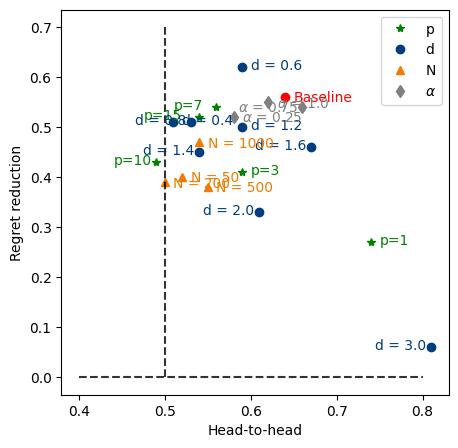

In [31]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5, 5))
p_indices = [0,1,3,4,5]
plt.plot(h2h_P_ante[p_indices], regret_P_ante[p_indices], color='green', marker = "*", label = 'p', linestyle = 'None')
plt.text(h2h_P_ante[p_indices[0]] + 0.01, regret_P_ante[p_indices[0]] - 0.005, 'p='+str(num_feat_all[p_indices[0]]), color='green')
plt.text(h2h_P_ante[p_indices[1]] + 0.01, regret_P_ante[p_indices[1]] - 0.005, 'p='+str(num_feat_all[p_indices[1]]), color='green')
plt.text(h2h_P_ante[p_indices[2]] - 0.05, regret_P_ante[p_indices[2]] - 0.005, 'p='+str(num_feat_all[p_indices[2]]), color='green')
plt.text(h2h_P_ante[p_indices[3]] - 0.05, regret_P_ante[p_indices[3]] - 0.005, 'p='+str(num_feat_all[p_indices[3]]), color='green')
plt.text(h2h_P_ante[p_indices[4]] - 0.065, regret_P_ante[p_indices[4]] - 0.005, 'p='+str(num_feat_all[p_indices[4]]), color='green')

plt.plot(h2h_d_ante[0], regret_d_ante[0], color='#003D7C', marker = "o", label = 'd', linestyle = 'None')
# plt.plot(h2h_d[1], mci_d[1], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[1], regret_d_ante[1], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[2], regret_d_ante[2], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[4], regret_d_ante[4], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[5], regret_d_ante[5], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[6], regret_d_ante[6], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[7], regret_d_ante[7], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[8], regret_d_ante[8], color='#003D7C', marker = "o", linestyle = 'None')


plt.text(h2h_d_ante[0] + 0.01, regret_d_ante[0] - 0.005, 'd = '+str(deg_all[0]), color='#003D7C')
# plt.text(h2h_d[1] + 0.007, mci_d[1] - 0.003, 'd = 15', color='#003D7C')
plt.text(h2h_d_ante[1] + 0.01, regret_d_ante[1] - 0.005, 'd = '+str(deg_all[1]), color='#003D7C')
plt.text(h2h_d_ante[2] - 0.065, regret_d_ante[2] - 0.005, 'd = '+str(deg_all[2]), color='#003D7C')
plt.text(h2h_d_ante[4] + 0.01, regret_d_ante[4] - 0.005, 'd = '+str(deg_all[4]), color='#003D7C')
plt.text(h2h_d_ante[5] - 0.065, regret_d_ante[5] - 0.005, 'd = '+str(deg_all[5]), color='#003D7C')
plt.text(h2h_d_ante[6] - 0.065, regret_d_ante[6] - 0.005, 'd = '+str(deg_all[6]), color='#003D7C')
plt.text(h2h_d_ante[7] - 0.065, regret_d_ante[7] - 0.005, 'd = '+str(deg_all[7]), color='#003D7C')
plt.text(h2h_d_ante[8] - 0.065, regret_d_ante[8] - 0.005, 'd = '+str(deg_all[8]), color='#003D7C')


plt.plot(h2h_N_ante[0], regret_N_ante[0], color='#EF7C00', marker = "^", label = 'N',linestyle = 'None')
plt.text(h2h_N_ante[1] + 0.01, regret_N_ante[1] - 0.01, 'Baseline', color='red')
# plt.plot(h2h_N[1], mci_N[1], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N_ante[2], regret_N_ante[2], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N_ante[3], regret_N_ante[3], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N_ante[4], regret_N_ante[4], color='#EF7C00', marker = "^",linestyle = 'None')
plt.text(h2h_N_ante[0] + 0.01, regret_N_ante[0] - 0.01, 'N = 50', color='#EF7C00')
# plt.text(h2h_N[1] + 0.005, mci_N[1] - 0.003, 'N = 100', color='#EF7C00')
plt.text(h2h_N_ante[2] + 0.01, regret_N_ante[2] - 0.01, 'N = 200', color='#EF7C00')
plt.text(h2h_N_ante[3] + 0.01, regret_N_ante[3] - 0.01, 'N = 500', color='#EF7C00')
plt.text(h2h_N_ante[4] + 0.01, regret_N_ante[4] - 0.01, 'N = 1000', color='#EF7C00')


plt.plot(h2h_e_ante[0], regret_e_ante[0], color='grey', marker = "d", label = r'$\alpha$',linestyle = 'None')
# plt.plot(h2h_alpha[1], mci_alpha[1], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_e_ante[2], regret_e_ante[2], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_e_ante[3], regret_e_ante[3], color='grey', marker = "d",linestyle = 'None')
plt.text(h2h_e_ante[0] + 0.01, regret_e_ante[0] - 0.01, r'$\alpha$ = 0.25', color='grey')
# plt.text(h2h_alpha[1] + 0.005, mci_alpha[1] - 0.005, r'$\alpha$ = 1', color='grey')
plt.text(h2h_e_ante[2] - 0.075, regret_e_ante[2] - 0.01, r'$\alpha$ = 0.75', color='grey')
plt.text(h2h_e_ante[3] + 0.01, regret_e_ante[3] - 0.01, r'$\alpha$ = 1.0', color='grey')

plt.vlines(0.5, 0.0, 0.7, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0.0, 0.4, 0.8, linestyle="dashed", alpha = 0.8,color = 'k')
plt.legend()

plt.xlabel('Head-to-head')
plt.ylabel('Regret reduction')

plt.plot(h2h_N_ante[1], regret_N_ante[1], color='red', marker = "o", linestyle = 'None')
# plt.annotate('Ridge vs. DDR', xy = (0.25,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

# fig.savefig(DataPath_parent+'DDR_vs_OLS_DPSN.eps', format='eps', bbox_inches="tight")
fig.savefig(Result_dir +'DDR_vs_OLS_diff_settings_ante.pdf', format='pdf', bbox_inches="tight")
plt.show()

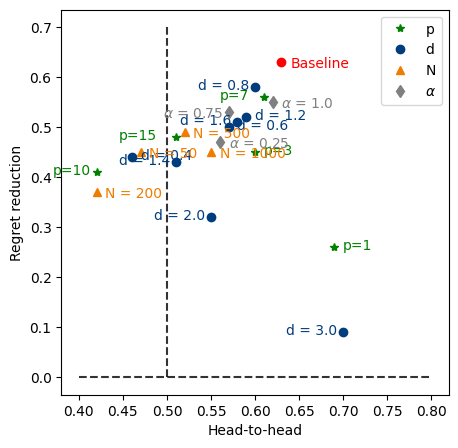

In [47]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5, 5))
p_indices = [0,1,3,4,5]
plt.plot(h2h_P_ante[p_indices], regret_P_ante[p_indices], color='green', marker = "*", label = 'p', linestyle = 'None')
plt.text(h2h_P_ante[p_indices[0]] + 0.01, regret_P_ante[p_indices[0]] - 0.005, 'p='+str(num_feat_all[p_indices[0]]), color='green')
plt.text(h2h_P_ante[p_indices[1]] + 0.01, regret_P_ante[p_indices[1]] - 0.005, 'p='+str(num_feat_all[p_indices[1]]), color='green')
plt.text(h2h_P_ante[p_indices[2]] - 0.05, regret_P_ante[p_indices[2]] - 0.005, 'p='+str(num_feat_all[p_indices[2]]), color='green')
plt.text(h2h_P_ante[p_indices[3]] - 0.05, regret_P_ante[p_indices[3]] - 0.005, 'p='+str(num_feat_all[p_indices[3]]), color='green')
plt.text(h2h_P_ante[p_indices[4]] - 0.065, regret_P_ante[p_indices[4]] - 0.005, 'p='+str(num_feat_all[p_indices[4]]), color='green')

plt.plot(h2h_d_ante[0], regret_d_ante[0], color='#003D7C', marker = "o", label = 'd', linestyle = 'None')
# plt.plot(h2h_d[1], mci_d[1], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[1], regret_d_ante[1], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[2], regret_d_ante[2], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[4], regret_d_ante[4], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[5], regret_d_ante[5], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[6], regret_d_ante[6], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[7], regret_d_ante[7], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d_ante[8], regret_d_ante[8], color='#003D7C', marker = "o", linestyle = 'None')


plt.text(h2h_d_ante[0] + 0.01, regret_d_ante[0] - 0.005, 'd = '+str(deg_all[0]), color='#003D7C')
# plt.text(h2h_d[1] + 0.007, mci_d[1] - 0.003, 'd = 15', color='#003D7C')
plt.text(h2h_d_ante[1] + 0.01, regret_d_ante[1] - 0.005, 'd = '+str(deg_all[1]), color='#003D7C')
plt.text(h2h_d_ante[2] - 0.065, regret_d_ante[2] - 0.005, 'd = '+str(deg_all[2]), color='#003D7C')
plt.text(h2h_d_ante[4] + 0.01, regret_d_ante[4] - 0.005, 'd = '+str(deg_all[4]), color='#003D7C')
plt.text(h2h_d_ante[5] - 0.065, regret_d_ante[5] - 0.005, 'd = '+str(deg_all[5]), color='#003D7C')
plt.text(h2h_d_ante[6] - 0.065, regret_d_ante[6] - 0.005, 'd = '+str(deg_all[6]), color='#003D7C')
plt.text(h2h_d_ante[7] - 0.065, regret_d_ante[7] - 0.005, 'd = '+str(deg_all[7]), color='#003D7C')
plt.text(h2h_d_ante[8] - 0.065, regret_d_ante[8] - 0.005, 'd = '+str(deg_all[8]), color='#003D7C')


plt.plot(h2h_N_ante[0], regret_N_ante[0], color='#EF7C00', marker = "^", label = 'N',linestyle = 'None')
plt.text(h2h_N_ante[1] + 0.01, regret_N_ante[1] - 0.01, 'Baseline', color='red')
# plt.plot(h2h_N[1], mci_N[1], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N_ante[2], regret_N_ante[2], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N_ante[3], regret_N_ante[3], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N_ante[4], regret_N_ante[4], color='#EF7C00', marker = "^",linestyle = 'None')
plt.text(h2h_N_ante[0] + 0.01, regret_N_ante[0] - 0.01, 'N = 50', color='#EF7C00')
# plt.text(h2h_N[1] + 0.005, mci_N[1] - 0.003, 'N = 100', color='#EF7C00')
plt.text(h2h_N_ante[2] + 0.01, regret_N_ante[2] - 0.01, 'N = 200', color='#EF7C00')
plt.text(h2h_N_ante[3] + 0.01, regret_N_ante[3] - 0.01, 'N = 500', color='#EF7C00')
plt.text(h2h_N_ante[4] + 0.01, regret_N_ante[4] - 0.01, 'N = 1000', color='#EF7C00')


plt.plot(h2h_e_ante[0], regret_e_ante[0], color='grey', marker = "d", label = r'$\alpha$',linestyle = 'None')
# plt.plot(h2h_alpha[1], mci_alpha[1], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_e_ante[2], regret_e_ante[2], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_e_ante[3], regret_e_ante[3], color='grey', marker = "d",linestyle = 'None')
plt.text(h2h_e_ante[0] + 0.01, regret_e_ante[0] - 0.01, r'$\alpha$ = 0.25', color='grey')
# plt.text(h2h_alpha[1] + 0.005, mci_alpha[1] - 0.005, r'$\alpha$ = 1', color='grey')
plt.text(h2h_e_ante[2] - 0.075, regret_e_ante[2] - 0.01, r'$\alpha$ = 0.75', color='grey')
plt.text(h2h_e_ante[3] + 0.01, regret_e_ante[3] - 0.01, r'$\alpha$ = 1.0', color='grey')

plt.vlines(0.5, 0.0, 0.7, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0.0, 0.4, 0.8, linestyle="dashed", alpha = 0.8,color = 'k')
plt.legend()

plt.xlabel('Head-to-head')
plt.ylabel('Regret reduction')

plt.plot(h2h_N_ante[1], regret_N_ante[1], color='red', marker = "o", linestyle = 'None')
# plt.annotate('Ridge vs. DDR', xy = (0.25,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

# fig.savefig(DataPath_parent+'DDR_vs_OLS_DPSN.eps', format='eps', bbox_inches="tight")
fig.savefig(Result_dir +f'DDR_vs_OLS_diff_settings_ante_mu={mu}_lamb={lamb}.pdf', format='pdf', bbox_inches="tight")
plt.show()